In [ ]:
!git clone https://github.com/AvonYangXX1/AMPLify-Feedback.git
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

Cloning into 'AMPLify-Feedback'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 335 (delta 155), reused 293 (delta 121), pack-reused 0
Receiving objects: 100% (335/335), 12.30 MiB | 3.15 MiB/s, done.
Resolving deltas: 100% (155/155), done.
Updating files: 100% (56/56), done.


In [ ]:
def read_data(i):
    seq_train = np.load(f"AMPLify-Feedback/processed_data/cv/seq_train_{i}.npy")
    state_train = np.load(f"AMPLify-Feedback/processed_data/cv/state_train_{i}.npy")
    label_train = np.load(f"AMPLify-Feedback/processed_data/cv/label_train_{i}.npy")
    seq_val = np.load(f"AMPLify-Feedback/processed_data/cv/seq_val_{i}.npy")
    state_val = np.load(f"AMPLify-Feedback/processed_data/cv/state_val_{i}.npy")
    label_val = np.load(f"AMPLify-Feedback/processed_data/cv/label_val_{i}.npy")
    seq_train = tf.one_hot(seq_train.squeeze(), depth=43)
    seq_val = tf.one_hot(seq_val.squeeze(), depth=43)
    return seq_train, state_train, label_train, seq_val, state_val, label_val

In [ ]:
class RMSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.loss=tf.keras.losses.MeanSquaredError()

    def call(self, y_true, y_pred):
        loss0 = tf.sqrt(self.loss(y_true, y_pred))
        return loss0

class UsefulFraction(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, name='UsefulFraction', **kwargs):
        super(UsefulFraction, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total_count = self.add_weight(name='total_count', initializer='zeros')
        self.within_threshold_count = self.add_weight(name='within_threshold_count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_true - y_pred)
        within_threshold = tf.cast(tf.less(error, self.threshold), tf.float32)
        self.total_count.assign_add(tf.reduce_sum(tf.ones_like(error)))
        self.within_threshold_count.assign_add(tf.reduce_sum(within_threshold))

    def result(self):
        return self.within_threshold_count / self.total_count

    def reset_states(self):
        self.total_count.assign(0)
        self.within_threshold_count.assign(0)

In [ ]:
def visualize_pred(pred, label):
    meta = LinearRegression()
    meta.fit(pred, label)
    line = meta.predict(pred)
    fig, axs = plt.subplots(1,1)
    axs.scatter(pred, label, marker="+", color="royalblue", alpha=0.5)
    axs.plot(pred, line, color="black")
    axs.set_xlabel("Predicted")
    axs.set_ylabel("True")

In [ ]:
def create_model():
    inputs0 = tf.keras.layers.Input((190,43),name="SeqInput")
    inputs1 = tf.keras.layers.Input((326,),name="StateInput")
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_0")(inputs0) # kernel_size=5 works well
    x = tf.keras.layers.Conv1D(128, 5, activation='relu', name="Conv1D_1")(x) # Just two layers work better
    x = tf.keras.layers.Flatten(name="Flatten_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnSeqDense_0")(x)
    x = tf.keras.layers.Concatenate(axis=1, name="Concat")([x, inputs1])
    x = tf.keras.layers.Dense(1024, activation="relu", name="LearnConcatDense_0")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_0")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="LearnConcatDense_1")(x)
    x = tf.keras.layers.LayerNormalization(name="LayerNorm_1")(x)
    x = tf.keras.layers.Dense(1, activation="linear", name="Output")(x)
    model = tf.keras.models.Model([inputs0, inputs1], x, name="MICPredictor")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[tf.keras.metrics.R2Score(), UsefulFraction()])
    return model

In [ ]:
mae = []
r2 = []
usefulness = []
# val_pred_log = []
for i in range(5):
    seq_train, state_train, label_train, seq_val, state_val, label_val = read_data(i)
    model = create_model()
    model.fit([seq_train, state_train], label_train, batch_size=100, verbose=0, epochs=30,
              validation_data=([seq_val, state_val], label_val))
    pred = model.predict([seq_val, state_val], verbose=0)
    # val_pred_log.append([label_val, pred])
    mae.append(mean_absolute_error(label_val, pred))
    r2.append(r2_score(label_val, pred))
    useful_metric = UsefulFraction()
    useful_metric.update_state(label_val, pred)
    usefulness.append(useful_metric.result())
    print(f"Fold {i}: MAE={mae[i]:4f}; R2={r2[i]:4f}; UsefulFraction={usefulness[i]:4f}")
    del seq_train, state_train, label_train, seq_val, state_val, label_val
print(f"Mean: MAE={np.mean(mae):4f}; R2={np.mean(r2):4f}; UsefulFraction={np.mean(usefulness):4f}")

Fold 0: MAE=0.967041; R2=0.492680; UsefulFraction=0.642043
Fold 1: MAE=0.973508; R2=0.498457; UsefulFraction=0.630647
Fold 2: MAE=0.990494; R2=0.480679; UsefulFraction=0.628612
Fold 3: MAE=1.005967; R2=0.444955; UsefulFraction=0.633293
Fold 4: MAE=1.019270; R2=0.465119; UsefulFraction=0.616121
Mean: MAE=0.991256; R2=0.476378; UsefulFraction=0.630143


In [ ]:
seq_train = np.load("AMPLify-Feedback/processed_data/test/seq_cv.npy")
state_train = np.load("AMPLify-Feedback/processed_data/test/state_cv.npy")
label_train = np.load("AMPLify-Feedback/processed_data/test/label_cv.npy")
seq_test = np.load("AMPLify-Feedback/processed_data/test/seq_test.npy")
state_test = np.load("AMPLify-Feedback/processed_data/test/state_test.npy")
label_test = np.load("AMPLify-Feedback/processed_data/test/label_test.npy")
seq_train = tf.one_hot(seq_train.squeeze(), depth=43)
seq_test = tf.one_hot(seq_test.squeeze(), depth=43)

In [ ]:
model = create_model()
model.fit([seq_train, state_train], label_train, batch_size=100, verbose=0,
          epochs=30, validation_data=([seq_test, state_test], label_test))
pred = model.predict([seq_test, state_test], verbose=0)
mae = mean_absolute_error(label_test, pred)
r2 = r2_score(label_test, pred)
useful_metric = UsefulFraction()
useful_metric.update_state(label_test, pred)
usefulness = useful_metric.result()
print(f"MAE={mae:4f}; R2={r2:4f}; UsefulFraction={usefulness:4f}")

MAE=0.950209; R2=0.503971; UsefulFraction=0.659775


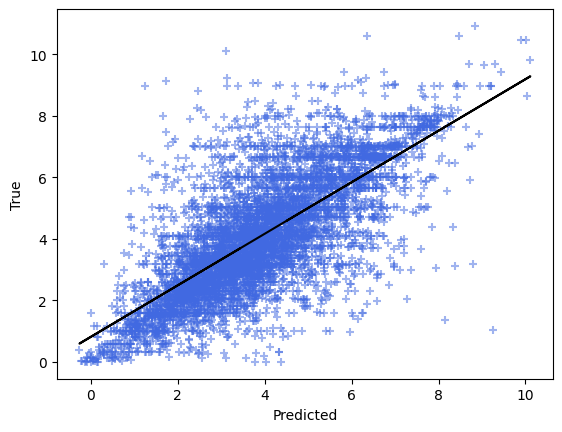

In [ ]:
meta = LinearRegression()
meta.fit(pred, label_test)
line = meta.predict(pred)
fig, axs = plt.subplots(1,1)
axs.scatter(pred, label_test, marker="+", color="royalblue", alpha=0.5)
axs.plot(pred, line, color="black")
axs.set_xlabel("Predicted")
axs.set_ylabel("True")
# axs.set_title("Predictive Results on the Test Dataset")
plt.savefig("oracle_performance.png")

In [ ]:
seq = np.load("AMPLify-Feedback/processed_data/test/seq_whole.npy")
state = np.load("AMPLify-Feedback/processed_data/test/state_whole.npy")
label = np.load("AMPLify-Feedback/processed_data/test/label_whole.npy")
seq = tf.one_hot(seq.squeeze(), depth=43)

In [ ]:
model = create_model()
model.fit([seq, state], label, batch_size=100, verbose=0, epochs=30)

In [ ]:
path = "AMPLify-Feedback/model_weights/MICPredictor"
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    np.save(f'{path}/layer_{i}_weights.npy', weights)

In [ ]:
# model.save("AMPLify-Feedback/model_weights/MICPredictor.keras")

In [ ]:
# model.save_weights("AMPLify-Feedback/model_weights/MICPredictor.weights.h5")